## Section Headings Curation and sentences spliter of Chilean Policies

In this notebook there are a series of dictionaries and methods to curate section headings of El Salvador policies. Policies from El Salvador have a rather definite structure, so that the law text is organized under section headings. There are two kinds of sections, the ones that are general and that can be often found in many policies, and the ones which are specific. The sections headings which are more general often come with a whole range of name variants which makes the task of machine recognition difficult.

The goal of this notebook is to group all pretreatment methods that would harmonize sections heading to make the further processing machine friendly.

In [1]:
from pathlib import Path
import boto3, json, operator, os, re, string
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Dictionaries of particular vocabularies to help in the curation of section headings

In [63]:
# Most policies come with the final signatures. This is a piece of text that we want to be able to recognize. To make the
# detection of signatures easier, this dictionary contain the most common terms that can be found in these lines of text.
official_positions = {"ALCALDE" : 0,
"Alcalde" : 0,
"MINISTRA" : 0,
"Ministra" : 0,
"MINISTRO" : 0,
"Ministro" : 0,
"PRESIDENTA" : 0,
"Presidenta" : 0,
"PRESIDENTE" : 0,
"Presidente" : 0,
"REGIDOR" : 0,
"Regidor"  : 0,
"REGIDORA" : 0,
"regidora" : 0,
"SECRETARIA" : 0,
"Secretaria" : 0,
"SECRETARIO" : 0,
"Secretario" : 0,
"SINDICA" : 0,
"Sindica" : 0,
"SINDICO" : 0,
"Sindico" : 0,
"VICEPRESIDENTA" : 0,
"Vicepresidenta" : 0,
"VICEPRESIDENTE" : 0,
"Vicepresidente" : 0
}

end_of_file_tags = {
    "Anótese" : 0,
    "Anotese" : 0,
    "Publíquese" : 0,
    "Publiquese" : 0
}
# This dictionary contains some correspondences among different text headings. This is under development and needs further
# improvement.The idea is to merge in a single name all the headings that point to the same conceptual concept. For example,
# "Definiciones" is a heading that can come alone or together with other terms so it can appear as "Definiciones básicas" or
# "Definiciones generales". With the dictionary we can fetch all headings that contain the word "Definiciones" and change the
# heading to "Definiciones".
merges = {
    "CONCEPTOS" : "DISPOSICIONES GENERALES",
    "Considerando:" : "CONSIDERANDO",
    "DEFINICIONES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES FINALES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES GENERALES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES PRELIMINARES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES REGULADORAS" : "DISPOSICIONES ESPECIALES",
    "DISPOSICIONES RELATIVAS" : "DISPOSICIONES ESPECIALES",
    "DISPOSICIONES ESPECIALES" : "DISPOSICIONES ESPECIALES",
    "DISPOSICIONES TRANSITORIAS" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES VARIAS Y TRANSITORIAS" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES VARIAS" : "DISPOSICIONES GENERALES",
    "INCENTIVOS" : "INCENTIVOS",
    "INFRACCIONES" : "INFRACCIONES",
    "INFRACCION ES" : "INFRACCIONES",
    "OBJETIVO" : "OBJETO",
    "OBJETO" : "OBJETO",
    "DERECHOS" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "DEBERES" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGACIONES" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGACIONE" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGACION" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGATORIEDAD" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "PROHIBICIONES" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "PROHIBICION" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "DE LAS FORMAS DE AUTORIZACION" : "PERMISOS",
    "DE LOS PERMISOS Y LAS PATENTES" : "PERMISOS",
    "DE LOS PERMISOS" : "PERMISOS",
    "DE LAS SOLICITUDES DE PERMISOS" : "PERMISOS",
    "DEL OTORGAMIENTO DEL PERMISO" : "PERMISOS",
    "POR TANTO" : "POR TANTO",
    "POR LO TANTO" : "POR TANTO",
    "Decreto:" : "RESUELVO",
    "Resuelvo:" : "RESUELVO",
    "Se resuelve" : "RESUELVO",
    "S e  r e s u e l v e:" : "RESUELVO",
    "R e s u e l v o:" : "RESUELVO",
    "FISCALIZACION Y SANCIONES" : "SANCIONES",
    "DE LAS SANCIONES" : "SANCIONES",
    "Visto:" : "VISTO",
    "Vistos:" : "VISTO",
    "Vistos estos antecedentes:" : "VISTO",
    "--------------" : "HEADING"
}
section_tags = {
    "Considerando:" : "CONSIDERANDO",
    "Considerando\n" : "CONSIDERANDO",
    "Decreto:" : "RESUELVO",
    "Disposiciones Generales" : "DISPOSICIONES GENERALES", 
    "Resuelvo:" : "RESUELVO",
    "R e s u e l v o:" : "RESUELVO",
    "Se resuelve" : "RESUELVO",
    "S e  r e s u e l v e:" : "RESUELVO",
    "Visto:" : "VISTO",
    "Vistos:" : "VISTO",
    "Vistos estos antecedentes:" : "VISTO",
    "--------------" : "HEADING"
}
merges_lower = {}
for key, value in merges.items():
    merges_lower[key.lower()] = value
# Eventhough the general gramar rule in Spanish is not to accent uppercase, there are many cases where a word in a heding might
# appear accented. This is a dictionary to armonize all headings without accents. The list is rather comprehensive, but there is
# still room for improvement.
# If we find some bug beyond simple misspelling which will be solved by spell checker, we can include it here. The example is in
# the first row with "ACTIVIDADESUSOS" which was found several times in headings.
bugs = {"ACTIVIDADESUSOS" : "ACTIVIDADES DE USOS"}

### Connection to the AWS S3 bucket
To effectively run this cell you need Omdena's credentials. Please keep them local and do not sync them in GitHub repos nor cloud drives. Before doing anything with this json file, please think of security!!

In [64]:
json_folder = Path("C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/credentials/")
# json_folder = Path("C:/Users/jordi/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/credentials/")
filename = "Omdena_key_S3.json"
file = json_folder / filename

with open(file, 'r') as f:
    cred = json.load(f) 

for key in cred:
    KEY = key
    SECRET = cred[key]

s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-2',
    aws_access_key_id = KEY,
    aws_secret_access_key = SECRET
)

### Regular expressions

In [65]:

# To clear html tags (here is basically to remove the page tags)
cleanr = re.compile(r'<.*?>')

# To catch accents and dictionary to change them
accents_out = re.compile(r'[áéíóúÁÉÍÓÚ]')
accents_dict = {"á":"a","é":"e","í":"i","ó":"o","ú":"u","Á":"A","É":"E","Í":"I","Ó":"O","Ú":"U"}

# To remove special characters
clean_special_char = re.compile(r'(\*\.)|(\”\.)')

# To search for acronyms
clean_acron = re.compile(r'(A\s*\.M\s*\.)|(\b[Aa][Rr][Tt][Ss]*\s*\.)|(\b[Aa][Vv]\s*\.)|(\b[Dd]r\s*\.)|(\b[Ii]ng\s*\.)|(\b[Ll]ic\s*\.)|(\b[Ll]icda\s*\.)|(\bLIC\s*\.)|(mm\s*\.)|(mts\s*\.)|([Oo]rd\s*\.)|(\bNo\s*\.)|(\b[Nn]º\s*s*\.)|(P\s*\.M\s*\.)|(\b[Pp]rof\s*\.)|(\b[Pp]rofa\s*\.)|(\bsp\s*\.)|(\bssp\s*\.)|(\b[Ss]\*[Aa]\s*\.)|(\b[Ss]r\s*\.)|(\b[Ss]ra\s*\.)|(\bto\s*\.)|(\bta\s*\.)|(\b[Vv]ar\s*\.)')  

# Remove extra white spaces
whitespaces = re.compile(r'[ ]{2,}')

# Regular expression to clear punctuation from a string
clean_punct = re.compile('[%s]' % re.escape(string.punctuation))
clean_period = re.compile(r'\.')
# Regular expression to clear words that introduce unnecessary variability to headings. Some regex still not work 100% we need
# to improve them.
clean_capitulo = re.compile(r'(APARTADO \S*)|(APARTADO\s)|(^ART\.\s*\S*)|(^ART\.\s*)|(^Art\.\s*\S*)|(^Art\.\s*)|(^Arts\.\s*\S*)|(^[Aa][Rr][Tt][Ii][Cc][Uu][Ll][Oo]\.*\s*\S*\.-)|(Capítulo \S*)|(CAPITULO \S*)|(CAPITULO\S*)|(CAPÍTULO \S*)|(CAPITULÓ \S*)|(CAPITULOS \S*)|(CAPITUO \S*)|(CATEGORIA\b)|(CATEGORÍA\b)|(SUBCATEGORIA\b)|(SUBCATEGORÍA\b)|(TITULO\s\S*)|(TÍTULO\s\S*)')
clean_bullet_char = re.compile(r'^[A-Za-z]\s*\.|^[A-Za-z]\s*\.\s*|^[A-Za-z]\s*\-\s*|^[A-Za-z]\s*\)\s*|\.\s*\b[B-Za-z]\b|^[A-Z]{1,4}\s*\.')
clean_bullet_number = re.compile(r'^\d+\s*\.\s*-|^\d+\s*\.\s*\d*|^\d+\s*\.\s*[A-Za-z]\s|^\d+\)|^\d+\D\s')
clean_bullet_point = re.compile(r'^-\s*')

### Functions

In [66]:
is_empty = re.compile(r'^\s*\r+\n*|^\s*\.\s*\r+\n*')
def is_empty_line(line):
    return bool(is_empty.findall(line))

is_line_break = re.compile(r'\.\s*$|\.\t*$|;\s*$|:\s*$|\s+y$|,\s*$|\d+\s*$')
def is_end_of_paragraph(line):
    return bool(is_line_break.findall(line))

# Function to calculate the uppercase ratio in a string. It is used to detect section headings
def uppercase_ratio(string):
    if len(re.findall(r'[a-z]',string)) == 0:
        return 1
    else:
        return(len(re.findall(r'[A-Z]',string))/len(re.findall(r'[a-z]',string)))

def end_of_heading(line, flag, content):
    if "URL" in line and "https:" in line:
        flag = False
        content = False
        return flag, content
    else:
        return flag, content

def is_section(line):
    section = False
    for key in section_tags:
        if key in line:
            section = True
            break
    return section
            
def end_of_document(line):
    end_of_file = False
    for key in end_of_file_tags:
        if key in line:
            end_of_file = True
            break
    return end_of_file

# Te function to clear html tags
def clean_html_tags(string):
  return cleanr.sub('', string)
    
def is_por_tanto(line):
    if "POR TANTO" in line:
        return True
    else:
        return False

# Function to remove the last lines of a document, the ones that contain the signatures of the officials. It depends on the
# dictionary "official_positions"
def remove_signatures(line):
    signature = False
    for key in official_positions:
        if key in line:
            signature = True
            break
    return signature

# Function to change accented words by non-accented counterparts. It depends on the dictionary "accent_marks_bugs" 
def remove_accents(string):
    for accent in accents_out.findall(string):
        string = string.replace(accent, accents_dict[accent])
    return string

# Function to merge headlines expressing the same concept in different words. It depends on the dictionary "merges"
def merge_concepts(line):
    for key in merges:
        if key in line:
            line = merges[key]
            break
    return line

def clean_bugs(line):
    for key in bugs:
        if key in line:
            line = line.replace(key, bugs[key])
    return line

def clean_special_characters(line):
    char = clean_special_char.findall(line)
    for item in char:
        for character in item:
            if character != '':
                line = line.replace(character, "")
    return line

def clean_acronyms(line):
    acro = clean_acron.findall(line)
    for item in acro:
        for acronym in item:
            if acronym != '':
                line = line.replace(acronym, clean_punct.sub('', acronym))
    return line

def clean_whitespace(line):
    if whitespaces.sub(' ', line).rstrip().lstrip() != None:
        return whitespaces.sub(' ', line).rstrip().lstrip()
    else:
        return line

decimal_points = re.compile(r'(\b\d+\s*\.\s*\d+|\(\.\)|\b\d+\.\s*[A-Za-z]|\b[A-Za-z]\.\s*\d+)')
def change_decimal_points(line):
    dec = decimal_points.findall(line)
    for decimal in dec:
        if decimal != '':
#             print(decimal)
            line = line.replace(decimal, clean_period.sub('^', decimal))
    return line

def get_decimal_points_back(line):
    line = line.replace("^", ".")
    return line
                
# Function sentence
def clean_sentence(string):
    string = clean_capitulo.sub('', string)
    string = clean_bullet_char.sub('', string).rstrip().lstrip()
    string = clean_bullet_number.sub('', string).rstrip().lstrip()
    string = clean_bullet_point.sub('', string).rstrip().lstrip()
    if string != "":
        return string
    else:
        return ""    
    
# points = re.compile(r'(\b\w+\s*\.\s*\b[^\d\W]+)')
# def check_points(line):
#     return points.findall(line)
#     print(points.findall(line))
# This is to check sentences that have just three words
points = re.compile(r'(\b\w+\b\s*){3,}')
def check_sentence(line):
    if points.findall(line):
        return True
    else:
        return False

def split_into_sentences(line, sep):
    sentence_list = []
    for sentence in line.split(sep):
        if check_sentence(sentence):
            sentence = sentence.rstrip().lstrip()
            sentence_list.append(sentence)
    return sentence_list

# Function to add items to the dictionary with duplicate removal
def add_to_dict(string, dictionary, dupl_dict):
    if string in dupl_dict or string == None:
        pass
    else:
        dupl_dict[string] = 0
        if string in dictionary:
            dictionary[string] = dictionary[string] + 1
        else:
            dictionary[string] = 1
    return dictionary
def full_cleaning(line):
    line = clean_html_tags(line)
    line = remove_accents(line)
    line = clean_special_characters(line)
    line = clean_bugs(line)
    line = clean_acronyms(line)
    line = clean_whitespace(line)
#     print(line)
    line = clean_sentence(line)
#     print(line)
    return line
def is_visto(string, section_name, counter, dictionary):
    if section_name == "VISTO" and len(split_into_sentences(string, ":")) > 1:
        visto = split_into_sentences(string, ":")
        for sentence in split_into_sentences(visto[1], ";"):
            counter += 1
            sentence_id = filename[0:7] + '_' + str(counter)
            dictionary[filename][section]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}
    elif section == "VISTO" and len(split_into_sentences(string, ":")) < 2:
        for sentence in split_into_sentences(string, ";"):
            counter += 1
            sentence_id = filename[0:7] + '_' + str(counter)
            dictionary[filename][section]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}
    return counter, dictionary

In [ ]:
test_string = "Que el Art. 204 Ordinal 3*. y 5”. de la Constitución, regula. A. Hola, em dic Jordi. B. No sé massa perquè l'Art *. 22 conté 22.34€. Tanmateix sembla que la Licda. una cosa. voldria  55.22. no fotis"
# test_string = "Prova senzilleta per veure què passa si no hi ha punt"
test_string = clean_sentence(test_string)
test_string = clean_special_characters(test_string)
test_string = clean_acronyms(test_string)
test_string = clean_whitespace(test_string)
test_string = change_decimal_points(test_string)
print(test_string)
sentences = []
[sentences.append(sentence) for sentence in split_into_sentences(test_string)]
print(sentences)
# print(sentences)

# if check_sentence(test_string):
#     

### Pipeline to process files from S3 bucket
By executing this cell you will go through all policies in El Salvador and process section headings that will be saved in a dictionary. This should be merged with the notebook that builds up the final json files out of plain txt files.

In [ ]:
in_folder = "text-extraction/"
out_folder = "JSON/"
counter = 0
name4 = {}
name5 = {}
name6 = {}
name7 = {}
for obj in s3.Bucket('wri-latin-talent').objects.all().filter(Prefix='text-extraction'):
    if in_folder in obj.key and obj.key.replace(in_folder, "") != "":# and filename in obj.key   # Un comment the previous string to run the code just in one sample document.
        file = obj.get()['Body'].read().decode('utf-8')  #get the file from S3 and read the body content
        lines = file.split("\n") # Split by end of line and pipe lines into a list
        file_name = obj.key.replace(in_folder, "").replace('.pdf.txt', '')        
        name4[file_name[0:4]] = 0
        name5[file_name[0:5]] = 0
        name6[file_name[0:6]] = 0
        name7[file_name[0:7]] = 0

        counter += 1

In [ ]:
print(counter)
print(len(name4))
print(len(name5))
print(len(name6))
print(len(name7))

In [ ]:
string_test = "     Artículo 26º.- Los traslados médicos deberán justificarse mediante la presentación de certificado médico. Podrá contemplarse por indicación médica un solo acompañante si el estado de salud así lo amerita.\r\n"
print(string_test)
if is_end_of_paragraph(string_test):
    print("yes")

In [67]:
in_folder = "Chile/full/"
out_folder = "JSON/"
filename = "0185327971f7a647a20ea48ad0d253fa2549ac63" # This is only if you want to test on a single file
# bag_of_words = {}
# sentences = []
# sentences_dict = {}
json_file = {}
for obj in s3.Bucket('wri-latin-talent').objects.all().filter(Prefix='Chile/full/'):
    if in_folder in obj.key and obj.key.replace(in_folder, "") != "":# and filename in obj.key   # Un comment the previous string to run the code just in one sample document.
        file = obj.get()['Body'].read().decode('utf-8')  #get the file from S3 and read the body content
        lines = file.split("\n") # Split by end of line and pipe lines into a list
        key = obj.key.replace(in_folder, out_folder).replace('pdf.txt', 'json')
        filename = key.replace('.json', '').replace(out_folder, '')
        print(filename)
        json_file[filename] = {}
        line_counter = 0
        heading_flag = True
        heading_content = False
        has_section = False
        end_of_paragraph = True
        json_file[filename]["HEADING"] = {"tags" : [], "sentences" : {}}
        for line in lines:
            if is_empty_line(line):
#                 print("empty")
                continue
#             print(line_counter)
#             print(line)
            line = clean_whitespace(line)
            # Processing document heading
            if heading_flag:
                if "Tipo Norma" in line:
                    heading_content = True
                if heading_content:
                    line = full_cleaning(line)
                    if line != None:
                        if ":" in line:
                            line_counter += 1
                            sentence_id = filename[0:7] + '_' + str(line_counter)
                            json_file[filename]["HEADING"]["sentences"][sentence_id] = {"text" : line, "labels" : []}
                            if len(line) != 0:
                                json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] = line
                        else:
                            if len(line) != 0:
                                json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] = json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] + " " + line
#                 print("**", line)
                heading_flag, heading_content = end_of_heading(line, heading_flag, heading_content)

            # Breaking when document signatures are found    
            elif end_of_document(line):
#                 print(line)
                break
            # Getting section headings
            elif (uppercase_ratio(line) == 1 and len(line) > 10 and line_counter > 0) or is_section(line):
#                 print("line--", line)
                line = remove_accents(line)
                line = clean_bugs(line)
                line = clean_sentence(line)
                if line == None:
                    continue
                else:
                    has_section = True
                    section = merge_concepts(line)
                    end_of_paragraph = True
#                     print("**", section)
                    if section not in json_file[filename]:
                        json_file[filename][section] = {"tags" : [], "sentences" : {}}
                    line_counter, json_file = is_visto(line, section, line_counter, json_file)

            elif has_section:
                line = full_cleaning(line)
                if line == None:
                    continue                    
                else:
                    if section == "VISTO":
                        line_counter, json_file = is_visto(line, section, line_counter, json_file)
                    else:
                        line = change_decimal_points(line)
                        if is_end_of_paragraph(line):
#                             print("end is yes", line)
                            if not end_of_paragraph:
                                json_file[filename][section]["sentences"][sentence_id]["text"] = json_file[filename][section]["sentences"][sentence_id]["text"] + " " + line                                
                                end_of_paragraph = True
                            else:
                                for sentence in split_into_sentences(line, "."):
                                    if len(sentence) != 0:
                                        sentence = get_decimal_points_back(sentence)
                                        line_counter += 1
                                        sentence_id = filename[0:7] + '_' + str(line_counter)
                                        json_file[filename][section]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}
                                        end_of_paragraph = True
                        else:
#                             print("end is not",line)
                            if end_of_paragraph:
                                if len(line) != 0:
                                    line = get_decimal_points_back(line)
                                    line_counter += 1
                                    sentence_id = filename[0:7] + '_' + str(line_counter)
                                    json_file[filename][section]["sentences"][sentence_id] = {"text" : line, "labels" : []}
                                    end_of_paragraph = False
                            else:
                                if len(line) != 0:
                                    json_file[filename][section]["sentences"][sentence_id]["text"] = json_file[filename][section]["sentences"][sentence_id]["text"] + " " + line
                            
#         s3.Object('wri-latin-talent', key).put(Body = str(json.dumps(json_file)))#This will save all the contents in the string variable "content" into a txt file in the Pre-processed folder
        


00029986237f77d713d2cf6451fb9b4a88eeeddd
001d742a7ee8b2e5b2583e0683d5e8dcb59b65f7
00251ab539abbc4c046593236e65d462983888ae
002c53058e85d383b057fa4cc25a6eb8e7d401e3
0031d55c90473158c09acded547d67d44be22325
003bebe9c5240e82e6de09f37b43cd4fdfdc0aeb
00434763867d6101054003829bfcba002581e042
0058c31b175befc120f2d0bebeabc42f02fbee3b
0066d2d2807026ad0439315e32fb6f8ab5d94af4
00a4528ab74327e2e52371a04741a6b677d80889
00abdb97553fd6745ba97425ff9a30fa8eb370c1
00b277afb2e446fc065815fb3dc14b114ab802f1
00d7509c395ad525fa4155a252fb8defaf1e4272
00d91bcac2667290e3fb42452f5241be28b031c2
00dce06383ae811f931dc45cba2264415df5b72e
010c03f3b734f9ee20c368573841516f798b242e
0117f4f5f4e792bb00aaa18da79d0562a0f3d3cd
011c604576f0a76dc3f485eae864546c899dccf2
011ef5183b901654ae82d86d43e5127ae982d032
01203a974410a65782afca6ff2c3bdb24a84b158
012fe65d33e065e1c381601f69644869ce4ce3dd
013a174010d4b8922489c85ccb2eb1ddf75070d4
0143181b7331514c749b91578a0dcc895a99f6e7
014c682777557d5a7333f178459e4959460dc9d2
01521829cda7b792

In [ ]:
json_file

In [68]:
out_folder = Path("C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/Data/Processed/")
filename = "Chile_V2_210109.json"
file = out_folder / filename
with open(file, 'w') as fp:
    json.dump(json_file, fp, indent=4)

In [11]:
# Loading back the sentences dictionary
out_folder = Path("C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/Data/Processed/")
filename = "Chile_V2_210109.json"
file = out_folder / filename
with open(file, 'r') as fp:
    json_file = json.load(fp)

In [ ]:
print(len(json_file))
# for k in sorted(sentences_dict):
#     print(k, ":", sentences_dict[k])

#### Short summary

In [ ]:
print("After preprocessing there are {} different headings in El Salvador policies".format(len(bag_of_words)))
print("{} documents have been processed".format(i))
print("There are {} lines of text as sentences".format(len(sentences)))

#### Dictionary items sorted by occurrence

In [ ]:
dict( sorted(bag_of_words.items(), key=operator.itemgetter(1),reverse=True))

#### Dictionary items sorted by heading text

In [ ]:
for k in sorted(bag_of_words):
    print(k, ":", bag_of_words[k])

In [26]:
sentence_length = {}
for filename in json_file:
    for section in json_file[filename]:
        for sentence_id in json_file[filename][section]["sentences"]:
            length = len(json_file[filename][section]["sentences"][sentence_id]["text"])
            if length in sentence_length:
                sentence_length[length] += 1
            else:
                sentence_length[length] = 1
            if length == 13:
                print(sentence_id, "--", json_file[filename][section]["sentences"][sentence_id])


0031d55_42 -- {'text': 'A Transelec S', 'labels': []}
011c604_18 -- {'text': 'Sitio web www', 'labels': []}
01a45df_49 -- {'text': 'De 801 a 1200', 'labels': []}
01da407_14 -- {'text': 'Vertice A Lat', 'labels': []}
01da407_15 -- {'text': 'Vertice B Lat', 'labels': []}
01da407_16 -- {'text': 'Vertice C Lat', 'labels': []}
01da407_17 -- {'text': 'Vertice D Lat', 'labels': []}
0461be2_12 -- {'text': '3.080 de 2003', 'labels': []}
0461be2_13 -- {'text': '3.139 de 2003', 'labels': []}
0461be2_14 -- {'text': '3.815 de 2003', 'labels': []}
0461be2_16 -- {'text': '3.333 de 2007', 'labels': []}
0461c90_15 -- {'text': 'Sitio web www', 'labels': []}
05d75c9_17 -- {'text': 'Sitio web www', 'labels': []}
0702296_15 -- {'text': '3.815 de 2003', 'labels': []}
07b5a63_20 -- {'text': '- Saluda a Ud', 'labels': []}
08b9fb3_18 -- {'text': 'Sitio web www', 'labels': []}
09815a0_14 -- {'text': '3.305 de 2003', 'labels': []}
09815a0_15 -- {'text': '3.306 de 2003', 'labels': []}
09815a0_16 -- {'text': '3.81

In [13]:
sentence_length_list = []
for key, value in sentence_length.items():
    sentence_length_list.append([round(key), round(value)])

In [14]:
sorted_length = sorted(sentence_length_list,key=lambda x: x[0])
df = pd.DataFrame(sorted_length, columns = ['Sentence_length','Frequency'])

In [9]:
round(df.describe())

,Sentence_length,Frequency
count,1250.0,1250.0
mean,687.0,150.0
std,502.0,394.0
min,0.0,1.0
25%,313.0,2.0
50%,626.0,15.0
75%,949.0,154.0
max,4877.0,5383.0


In [46]:
df[len(df)-20:len(df)]

,Sentence_length,Frequency
1230,2180,1
1231,2221,1
1232,2261,1
1233,2268,1
1234,2374,1
1235,2558,1
1236,2578,1
1237,2639,1
1238,2643,1
1239,2651,1


<AxesSubplot:xlabel='Sentence_length'>

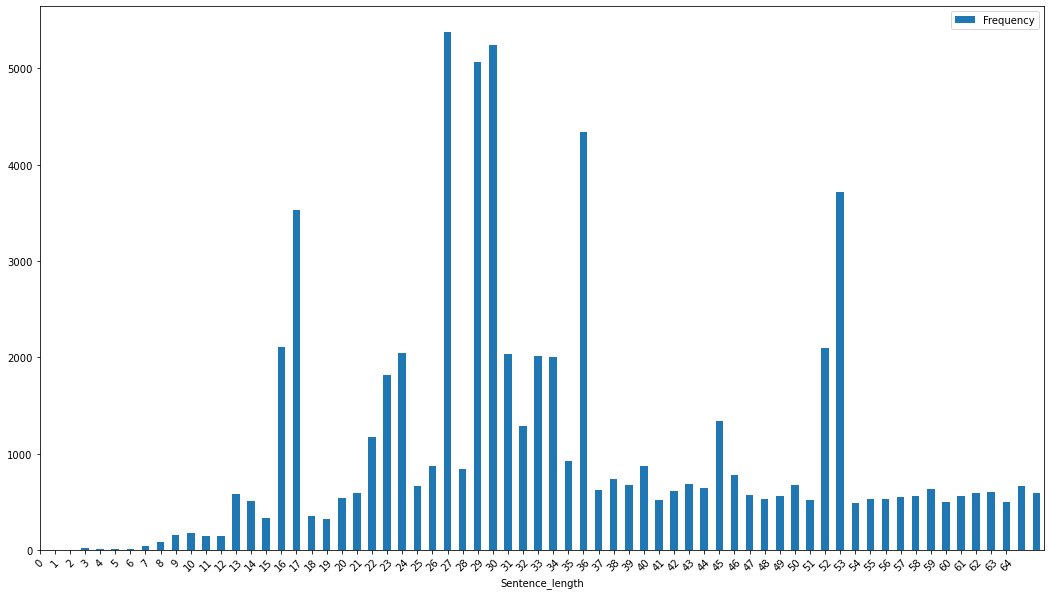

In [24]:
x_max = df["Sentence_length"].max()
x_max = 65
x_sep = 1
df[0:x_max].plot.bar(x='Sentence_length', y='Frequency', rot=45, figsize = (18, 10), xticks=range(0, x_max, x_sep), xlim = (0, x_max))

In [ ]:
sorted_arr = np.asarray(sorted_length)
labels, ys = zip(*sorted_arr)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)

# plt.savefig('netscore.png')

#### Saving sentences as csv

In [ ]:
print(sentences[0:2])

In [ ]:
# path = Path("C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/Data/")
path = Path("C:/Users/jordi/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/Data/")
filename = "sentences.npy"
file = path / filename
np_sentences = np.array(sentences)
with open(file, 'wb') as f:
    np.save(f, np_sentences)

### Pipeline to process one file from HD folder
This is a pipeline to process a test file in a local folder.

In [ ]:
path = "C:/Users/jordi/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Documents_de_mostra/Chile/"
# path = "C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Documents_de_mostra/Chile/"
files = os.listdir(path)
print(files[0])

In [ ]:
# path = "C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Documents_de_mostra/Chile/"
path = "C:/Users/jordi/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Documents_de_mostra/Chile/"
data_folder = Path(path)
filename = "00d91bcac2667290e3fb42452f5241be28b031c2"


files = os.listdir(path)
files = ["002c53058e85d383b057fa4cc25a6eb8e7d401e3"]

bag_of_words = {}
json_file = {}

i = 0
for filename in files:
#     if i == 0:
    file_ = data_folder / filename
    with open(file_, 'r', encoding = 'utf-8') as file:
        lines = file.readlines()
#         print("\n", filename, "\n")
        json_file[filename] = {}
        line_counter = 0
        heading_flag = True
        heading_content = False
        has_section = False
        json_file[filename]["HEADING"] = {"tags" : [], "sentences" : {}}
        for line in lines:
            line = clean_whitespace(line)
            # Processing document heading
            if heading_flag:
                if "Tipo Norma" in line:
                    heading_content = True
                if heading_content:
                    line = full_cleaning(line)
                    if line != None:
                        if ":" in line:
                            line_counter += 1
                            sentence_id = filename[0:7] + '_' + str(line_counter)
                            json_file[filename]["HEADING"]["sentences"][sentence_id] = {"text" : line, "labels" : []}
                            json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] = line
                        else:
                            json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] = json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] + " " + line
#                 print("**", line)
                heading_flag, heading_content = end_of_heading(line, heading_flag, heading_content)

            # Breaking when document signatures are found    
            elif end_of_document(line):
#                 print(line)
                break
            # Getting section headings
            elif (uppercase_ratio(line) == 1 and len(line) > 10 and line_counter > 0) or is_section(line):
#                 print("line--", line)
                line = remove_accents(line)
                line = clean_bugs(line)
                line = clean_sentence(line)
                if line == None:
                    continue
                else:
                    has_section = True
                    section = merge_concepts(line)
#                     print("**", section)
                    json_file[filename][section] = {"tags" : [], "sentences" : {}}
#                     bag_of_words = add_to_dict(section, bag_of_words, duplicates_dict)
                    if section == "VISTO" and len(split_into_sentences(line, ":")) > 1:
                        visto = split_into_sentences(line, ":")
                        for sentence in split_into_sentences(visto[1], ";"):
                            line_counter += 1
                            sentence_id = filename[0:7] + '_' + str(line_counter)
                            json_file[filename][section]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}

            elif has_section:
                line = full_cleaning(line)
                if line == None:
                    continue                    
                else:
                    line = change_decimal_points(line)
                    for sentence in split_into_sentences(line, "."):
                        line_counter += 1
                        sentence_id = filename[0:7] + '_' + str(line_counter)
                        json_file[filename][section]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}
        i += 1
    #     data = file.read().replace('\n', '')

In [ ]:
json_file

#### Dictionary items sorted by occurrence

In [ ]:
dict( sorted(bag_of_words.items(), key=operator.itemgetter(1),reverse=True))

#### Dictionary items sorted by heading text

In [ ]:
for k in sorted(bag_of_words):
    print(k, ":", bag_of_words[k])